In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import cleaning_functions as cfs
from matplotlib.pylab import rcParams
sns.set_style('white')
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.easter import easter
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error as mse

In [5]:
data = cfs.load_data_top_27()

In [8]:
data.head(2)

,60804,60085,60153,60110,60104,60505,60651,60073,60436,60639,...,60456,60034,46327,60180,60633,46324,60099,46320,46394,60162
time,,,,,,,,,,,,,,,,,,,,,
2013-01-01,79100.0,67100.0,84500.0,88500.0,84500.0,75800.0,95500.0,86700.0,71600.0,140200.0,...,88300.0,136700.0,NaN,165300.0,84600.0,73400.0,84900.0,NaN,90200.0,113600.0
2013-02-01,78400.0,66600.0,83300.0,88500.0,83700.0,74200.0,91600.0,86800.0,71000.0,138800.0,...,89300.0,135800.0,NaN,165900.0,83800.0,73700.0,83900.0,NaN,89200.0,114400.0


In [9]:
data['ds'] = data.index

In [12]:
data.head(2)

,60804,60085,60153,60110,60104,60505,60651,60073,60436,60639,...,60034,46327,60180,60633,46324,60099,46320,46394,60162,ds
time,,,,,,,,,,,,,,,,,,,,,
2013-01-01,79100.0,67100.0,84500.0,88500.0,84500.0,75800.0,95500.0,86700.0,71600.0,140200.0,...,136700.0,NaN,165300.0,84600.0,73400.0,84900.0,NaN,90200.0,113600.0,2013-01-01
2013-02-01,78400.0,66600.0,83300.0,88500.0,83700.0,74200.0,91600.0,86800.0,71000.0,138800.0,...,135800.0,NaN,165900.0,83800.0,73700.0,83900.0,NaN,89200.0,114400.0,2013-02-01


In [14]:
new_data = data.loc[:, ['ds', 46327, 60505, 60436, 60651, 60633]]

In [19]:
new_data.tail()

,ds,46327,60505,60436,60651,60633
time,,,,,,
2017-12-01,2017-12-01,73200.0,125500.0,111200.0,142900.0,110400.0
2018-01-01,2018-01-01,72700.0,127600.0,112700.0,145200.0,111500.0
2018-02-01,2018-02-01,72900.0,129200.0,114100.0,148300.0,112800.0
2018-03-01,2018-03-01,74000.0,131100.0,116100.0,150300.0,113300.0
2018-04-01,2018-04-01,74400.0,132100.0,117700.0,150900.0,113000.0


In [22]:
fb1_data = new_data.loc[:, ['ds', 46327]]

In [25]:
fb1_data.rename(columns={46327: 'y'})
fb1_data.head(2)

,ds,46327
time,,
2013-01-01,2013-01-01,NaN
2013-02-01,2013-02-01,NaN


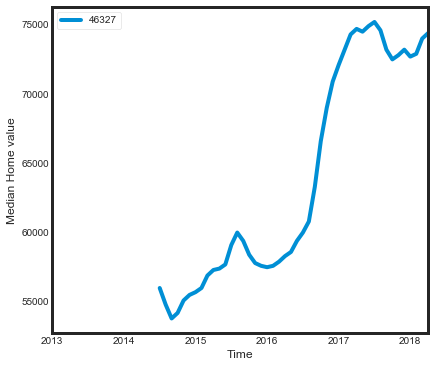

In [30]:
pd.plotting.register_matplotlib_converters()
ax = fb1_data.set_index('ds').plot(figsize=(6,6))
ax.set_ylabel('Median Home value')
ax.set_xlabel('Time')

plt.show()

In [40]:
fb1 = pd.DataFrame()
fb1['ds'] = pd.date_range(start='2014-07-01', end='2018-04-01', freq='MS')
fb1['y'] = fb1_data[46327].dropna().values
fb1

,ds,y
0,2014-07-01,56000.0
1,2014-08-01,54800.0
2,2014-09-01,53800.0
3,2014-10-01,54200.0
4,2014-11-01,55100.0
5,2014-12-01,55500.0
6,2015-01-01,55700.0
7,2015-02-01,56000.0
8,2015-03-01,56900.0
9,2015-04-01,57300.0


In [41]:
model = Prophet(interval_width=.95)
model.fit(fb1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
future_dates = model.make_future_dataframe(periods=12, freq='MS')
future_dates.tail()

,ds
53,2018-12-01
54,2019-01-01
55,2019-02-01
56,2019-03-01
57,2019-04-01


In [44]:
forecast = model.predict(future_dates)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-07-01,54132.169422,54727.207321,55942.594187,54132.169422,54132.169422,1163.172628,1163.172628,1163.172628,1163.172628,1163.172628,1163.172628,0.0,0.0,0.0,55295.342051
1,2014-08-01,54482.753997,54432.982107,55759.722434,54482.753997,54482.753997,639.484311,639.484311,639.484311,639.484311,639.484311,639.484311,0.0,0.0,0.0,55122.238308
2,2014-09-01,54833.338595,53822.918655,55082.014679,54833.338595,54833.338595,-402.929988,-402.929988,-402.929988,-402.929988,-402.929988,-402.929988,0.0,0.0,0.0,54430.408607
3,2014-10-01,55172.614013,53756.181310,55090.350057,55172.614013,55172.614013,-754.297525,-754.297525,-754.297525,-754.297525,-754.297525,-754.297525,0.0,0.0,0.0,54418.316488
4,2014-11-01,55523.200023,54201.412311,55462.724786,55523.200023,55523.200023,-688.952731,-688.952731,-688.952731,-688.952731,-688.952731,-688.952731,0.0,0.0,0.0,54834.247292


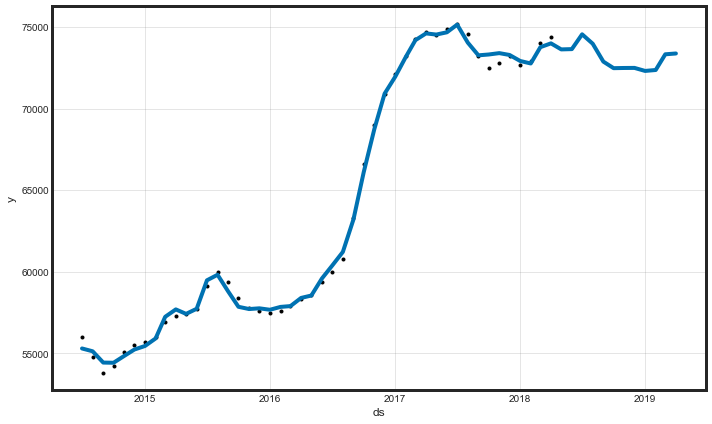

In [46]:
model.plot(forecast, uncertainty=False)
plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


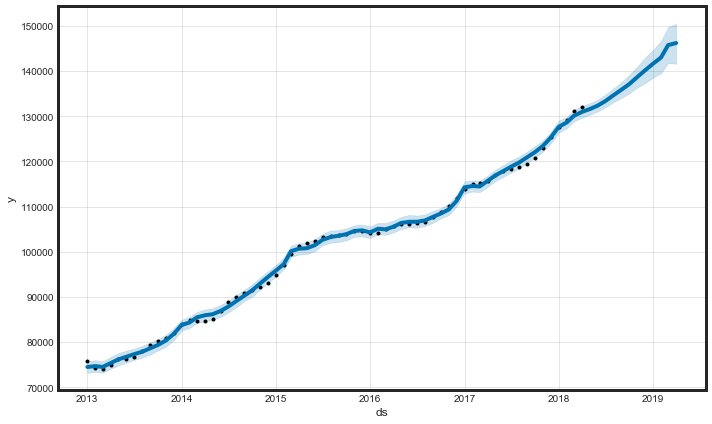

In [51]:
fb2 = pd.DataFrame()
fb2['ds'] = pd.date_range(start='2013-01-01', end='2018-04-01', freq='MS')
fb2['y'] = new_data[60505].values
model = Prophet(interval_width=.95)
model.fit(fb2)
future_dates = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future_dates)
model.plot(forecast, uncertainty=True)
plt.show()

,ds,y
0,2013-01-01,75800.0
1,2013-02-01,74200.0
2,2013-03-01,74000.0
3,2013-04-01,74900.0
4,2013-05-01,76200.0
...,...,...
59,2017-12-01,125500.0
60,2018-01-01,127600.0
61,2018-02-01,129200.0
62,2018-03-01,131100.0
